### Import modules

In [9]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series

#### Load data

In [10]:
data_path = os.path.abspath(os.path.join('..','..', 'data/f_e_forecast_gdp_europe.csv'))
file_tag = "GDP Europe"
target = "GDP"


def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Year",
        sep=",",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)

data.head()

,Birth_rate,CO2_emissions,Death_rate,Electric_power_consumption,Energy_use,Food_exports,Food_imports,Goods_services_exports,Goods_services_imports,Population_density,GDP
Year,,,,,,,,,,,
1960-01-01,18.580,5.762,10.233,1427.783,1720.317,NaN,NaN,NaN,NaN,NaN,359.029
1961-01-01,18.534,5.922,10.114,1523.150,1761.406,NaN,NaN,6.007,6.128,98.077,390.887
1962-01-01,18.337,6.209,10.441,1641.966,1869.038,17.703,23.804,5.810,7.448,98.948,427.015
1963-01-01,18.415,6.574,10.381,1758.415,1979.026,15.114,21.275,6.198,10.371,99.831,470.415
1964-01-01,18.510,6.790,10.051,1884.315,2045.755,14.513,19.838,9.225,9.728,100.706,521.328


### Preparation

In [11]:
def data_preparation(data):
    # Missing value 
    data: DataFrame = data.dropna(how="any", inplace=False) 

    # Train/test split
    train, test = series_train_test_split(data)   

    # Convert Series to DataFrame
    if isinstance(train, pd.Series):
        train = train.to_frame()
    if isinstance(test, pd.Series):
        test = test.to_frame()

    # Scaling
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(train)
    train_scaled = DataFrame(transf.transform(train), index=train.index, columns=train.columns)
    test_scaled = DataFrame(transf.transform(test), index=test.index, columns=test.columns) 

    # Smoothing
    WIN_SIZE = 25
    train_smooth: Series = train_scaled.rolling(window=WIN_SIZE).mean()
    train_smooth = train_smooth.dropna()

    # Differentiation
    train_diff: Series = train_smooth.diff()
    train_diff = train_diff.dropna()
    test_diff: Series = test_scaled.diff()
    test_diff = test_diff.dropna()
    train_diff: Series = train_diff.diff()
    train_diff = train_diff.dropna()
    test_diff: Series = test_diff.diff()
    test_diff = test_diff.dropna()

    return train_diff, test_diff
    
train, test = data_preparation(data)

print(train)
print(test)

            Birth_rate
Year                  
1988-01-01   -0.000311
1989-01-01   -0.001736
1990-01-01    0.002295
1991-01-01   -0.000219
1992-01-01   -0.002203
1993-01-01    0.000199
1994-01-01    0.000749
1995-01-01    0.001371
1996-01-01    0.000822
1997-01-01    0.002771
1998-01-01    0.001585
1999-01-01   -0.000705
2000-01-01    0.002373
2001-01-01   -0.000350
2002-01-01    0.001274
2003-01-01    0.001143
2004-01-01    0.000997
2005-01-01    0.000574
2006-01-01    0.002475
2007-01-01    0.001216
2008-01-01    0.002582
            Birth_rate
Year                  
2011-01-01   -0.033062
2012-01-01    0.021271
2013-01-01   -0.028808
2014-01-01    0.051051


#### Linear Regression

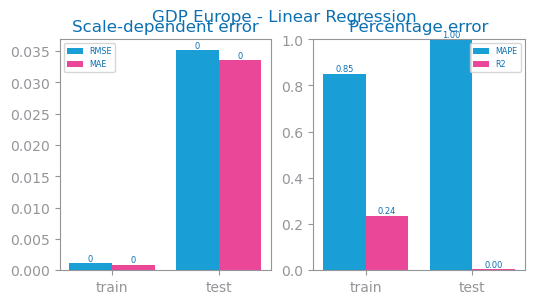

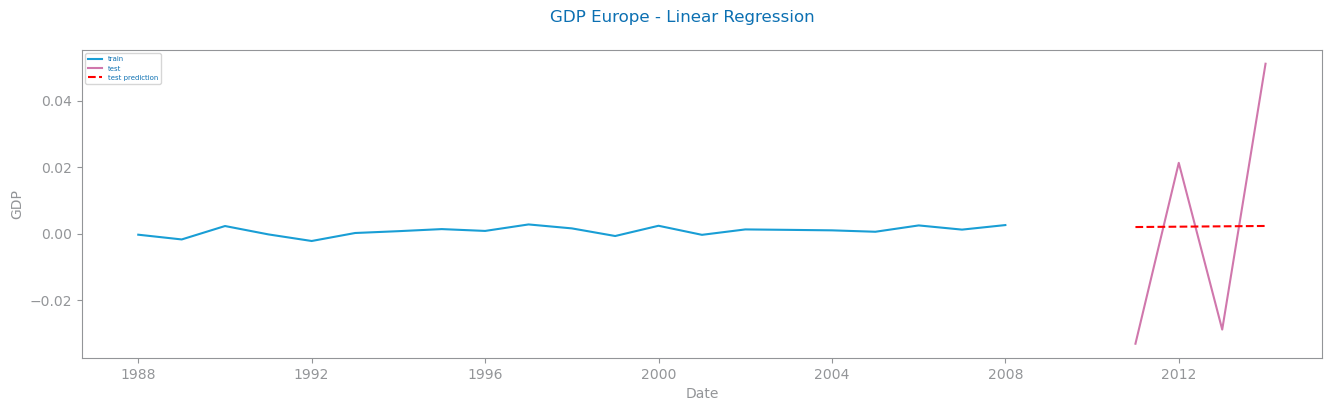

In [12]:
trnX = arange(len(train)).reshape(-1, 1)
trnY = train.values.ravel()
tstX = arange(len(train), len(train)+len(test)).reshape(-1, 1)
tstY = test.values.ravel()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}_linear_regression_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel="Date",
    ylabel=target,
)
savefig(f"images/{file_tag}_linear_regression_forecast.png")